In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from classes_hero import Hero
from classes_damageSource import DamageSource
from classes_dice import Dice, dice_dictionary

from plot_functions_bar import stacked_bar_plot_from_dict, draw_stacked_bar_plot, TICKSIZE, TITLESIZE

from myLittleHelpers import calc_growth

# Theorie: Damage per Round - Einleitung

Drei Punkte, die den Schaden pro Runde beeinflussen:
1. Trefferwahrscheinlichkeit
2. Waffenschaden (Damage Die + Bonus)
3. Kritische Treffer (Crits)

Kritische treffer sind eigentlich kein eigener Punkt, vielmehr sind Crits genauso eine Kombination aus Damage und Wahrscheinlichkeit.

# Trefferwahrscheinlichkeit

## Regeltechnischen Rahmenbedingungen
(vgl. PHB S.7, S.173, S.194)
* In D&D wird ein Treffer mit einem 20-seitigen Würfel ermittelt.
* Zu dem Würfelresultat wird der toHit-Bonus (Ability Modifier + Proficiency Bonus) hinzugezählt.
* Die ermittelte Zahl wird mit der Armour Class (AC) des Monsters verglichen.
    * Ist die Zahl größer, oder gleichgroß wie die AC des Monsters ("meets it beats it"), ist das ein Treffer.
    * Z.B. Bei einer AC von 13 und einem +3 toHit-Bonus muss ich 10 und höher würfeln.
* Trefferwahrscheinlichkeit ist also die Wahrscheinlichkeit über einem gewissen Wert zu liegen

### Proficiency Bonus
(vgl. PHB S.173)

Im Regelwerk ist nicht explizit eine Formel für die Berechnung des Proficiency Bonus angeführt, sondern es wird auf die Tabelle der jeweiligen Klassen verwiesen. Aus diesen Tabellen kann man ableiten, dass der Proficiency Bonus sich durch ein Viertel des Levels (aufgerundet) plus eins, ergibt.

* $ PB = \lceil \frac{Level}{4} \rceil +1 $ 

## Statistische Bemerkungen zur Trefferwahrscheinlichkeit
* Es gibt insgesamt 20 mögliche Kombinationen auf einem d20.
    * Jede Zahl steht für eine 5%ige Wahrscheinlichkeit.
* Wenn nun alles unter 10 ein Misserfolg wäre, kann man auch sagen:
    * Die AC des Monsters minus toHit Modifier ergibt die niedrigste Zahl, die noch trifft (=Mein gewünschtes Resultat).
    * 1 weniger als mein gewünschtes Resultat ergibt die höchste Zahl, die nicht trifft.
        * In unserem Fall: 9.
* Also ist die Wahrscheinlichkeit mit einem +3 toHit-Bonus eine AC 13 nicht zu treffen 9/20, oder 0,45.
    * Bzw. im Umkehrschluss: in 11 von 20 Fällen treffen wir, oder: wir haben eine 55%ige Wahrscheinlichkeit zu treffen.
    * $\frac{11}{20}=0,55=55\%$

### Formulierung 

$Trefferwahrscheinlichkeit (p) = 1 - \frac{(Benötigtes Ergebnis) -1}{20}$

$Benötigtes Ergebnis = AC-toHit$

$p = 1 - \frac{AC-toHit-1}{20}$

oder anders formuliert:

$p = \frac{20-AC+toHit+1}{20}$

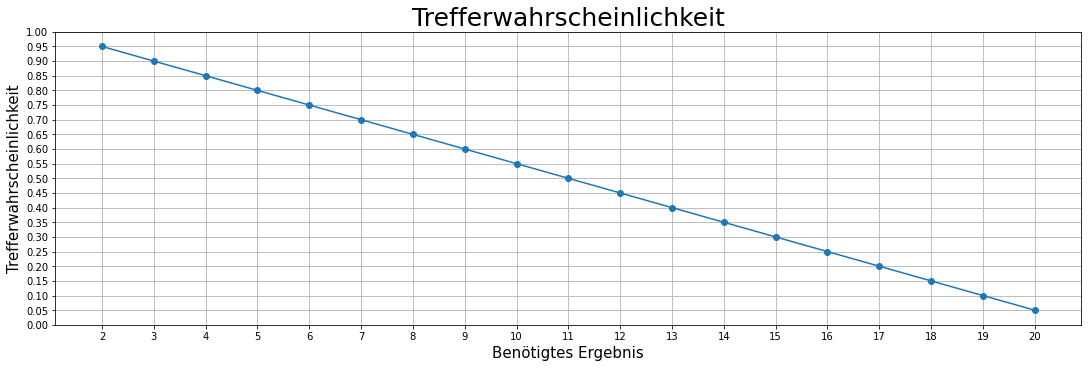

In [2]:
toHit_prob = pd.DataFrame(index=list(range(2,21)))
toHit_prob.index.name = "Benötigtes Ergebnis"
toHit_prob["Trefferwahrscheinlichkeit"] = 1-(toHit_prob.index-1)/20
# toHit_prob.transpose()

X = toHit_prob.index
# yerror = list(advDF["mit Advantage"]-advDF["Trefferwahrscheinlichkeit"])
fig, ax = plt.subplots(figsize=(15,5), layout="constrained")
ax.plot(X, toHit_prob["Trefferwahrscheinlichkeit"], "-o", label= "Trefferwahrscheinlichkeit")
ax.grid(True)
ax.set_xticks(ticks=X)
ax.set_yticks(ticks=np.linspace(0,1.0,21))
ax.set_xlabel("Benötigtes Ergebnis", fontsize=TICKSIZE)
ax.set_ylabel("Trefferwahrscheinlichkeit", fontsize=TICKSIZE)
ax.set_title("Trefferwahrscheinlichkeit", fontsize=TITLESIZE)
plt.show()

Wie erwartet, die linear abnehmende Trefferwahrscheinlichkeit, je höher das benötigte Ergebnis ist.

## Natural 1 und Natural 20

Man erkennt auch, dass die Wahrscheinlichkeit zu treffen nie 0, oder 1 ist. Dies hat mit den "Naturals" 1 bzw. 20 zu tun.

Denn wenn eine 1 immer verfehlt, dann kann 1 nie ein benötigtes ERgebnis sein, um eine AC zu treffen.

Auf der gleichen Weise, wenn 20 immer trifft, kann es keine 0% Chance zu treffen geben.

Daher ist die höchste Chance zu treffen 95% bzw. die geringste Chance einen Treffer zu landen 5%.

PHB S. 194: "If the d20 roll for an attack is a 20, the attack hits regardless of any modifiers or the target's AC. This is called a critical hit [...]. If the d20 roll for an attack is a 1, the attack misses regardless of any modifiers or the target's AC."

## Monster Armour Class

Neben dem toHit Modifikator wird die Trefferwahrscheinlichkeit von der Armour Class des zu bekämofenden Monsters bestimmt.

Der DMG (p. 274) stellt eine Liste zur Verfügung, die als Referenz für ein "durchschnittliches Monster" für das jeweilige Challenge Rating verwendet werden kann. Dort ist auch ein Wert für die empfohlene AC angegeben.

In [3]:
monster_stats = pd.read_csv("monsterStats_DMGp274.csv")
monster_stats

,CR,PB,AC,minHP,maxHP,ToHit,minDMG,maxDMG,saveDC,avgHP,avgDMG
0,0.000,2,12,1,6,3,0,1,13,3.5,0.5
1,0.125,2,13,7,35,3,2,3,13,21.0,2.5
2,0.250,2,13,36,49,3,4,5,13,42.5,4.5
3,0.500,2,13,50,70,3,6,8,13,60.0,7.0
4,1.000,2,13,71,85,3,9,14,13,78.0,11.5
5,2.000,2,13,86,100,3,15,15,13,93.0,15.0
6,3.000,2,13,101,115,4,21,26,13,108.0,23.5
7,4.000,2,14,116,130,5,27,32,14,123.0,29.5
8,5.000,3,15,131,145,6,33,38,15,138.0,35.5
9,6.000,3,15,146,160,6,39,44,15,153.0,41.5


## "Default" Trefferwahrscheinlichkeit pro Level

Aus dem Regelwerk des Spiels kann man ableiten welche Trefferwahrscheinlichkeit die Spielentwickler als "standard" festgelegt haben. Aus Spieldesign gründen wäre eine Trefferwahrscheinlichkeit wünschenswert, die dem Spieler Erfolge gönnt (nicht zu hoch) und dennoch fordernd für die Spieler ist (nicht zu niedrig).

Wie oben beschrieben setzt sich der toHit Bonus aus Modifier und Proficiency Bonus zusammen. Theoretisch kann der Modifier frei gewählt werden, eine erfahrungsgemäß solide Annahme wäre ein Startwert von 16 (+3 Modifier) für das Hauptattribut. Dieses Attribut kann bei Level 4 und 8 auf 18 (+4) bzw. 20 (+5) erhöht werden.

Die Veränderung des Proficiency Bonus per Level kann oben nachgelesen werden:

$ PB = \lceil \frac{Level}{4} \rceil +1 $ 

Dem gegenüber steht die Armour Class eines jeweiligen Monsters, die aus der oben angeführten Tabelle für das jeweilige Level entnommen werden kann.

In [4]:
tester_TW = Hero("Toni TW", toHitBonus=5)

tw_perLevel = pd.DataFrame(columns=["Level", "Proficiency Bonus", "ToHit Bonus", "Monster AC", "Trefferwahrscheinlichkeit"])
tw_perLevel["Level"] = list(range(1,21))
tw_perLevel["Monster AC"] = list(monster_stats["AC"][4:24])

pb_list = []
toHit_list = []
tw_list = []

for lvl, ac in zip(tw_perLevel["Level"], tw_perLevel["Monster AC"]):
    pb = math.ceil(lvl/4)+1
    pb_list.append(pb)
    if lvl >= 8:
        tester_TW.toHitBonus=5+pb
    elif lvl >= 4:
        tester_TW.toHitBonus=4+pb
    else:
        tester_TW.toHitBonus=3+pb

    toHit_list.append(tester_TW.toHitBonus)

    tester_TW.calcToHitChance(ac)
    tw_list.append(tester_TW.chance2Hit)

tw_perLevel["Proficiency Bonus"] = pb_list
tw_perLevel["ToHit Bonus"] = toHit_list
tw_perLevel["Trefferwahrscheinlichkeit"] = tw_list
tw_perLevel = tw_perLevel.set_index("Level")
tw_perLevel.transpose()

Level,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Proficiency Bonus,2.00,2.00,2.00,2.00,3.00,3.00,3.00,3.00,4.0,4.00,4.00,4.00,5.00,5.00,5.00,5.00,6.00,6.00,6.00,6.00
ToHit Bonus,5.00,5.00,5.00,6.00,7.00,7.00,7.00,8.00,9.0,9.00,9.00,9.00,10.00,10.00,10.00,10.00,11.00,11.00,11.00,11.00
Monster AC,13.00,13.00,13.00,14.00,15.00,15.00,15.00,16.00,16.0,17.00,17.00,17.00,18.00,18.00,18.00,18.00,19.00,19.00,19.00,19.00
Trefferwahrscheinlichkeit,0.65,0.65,0.65,0.65,0.65,0.65,0.65,0.65,0.7,0.65,0.65,0.65,0.65,0.65,0.65,0.65,0.65,0.65,0.65,0.65


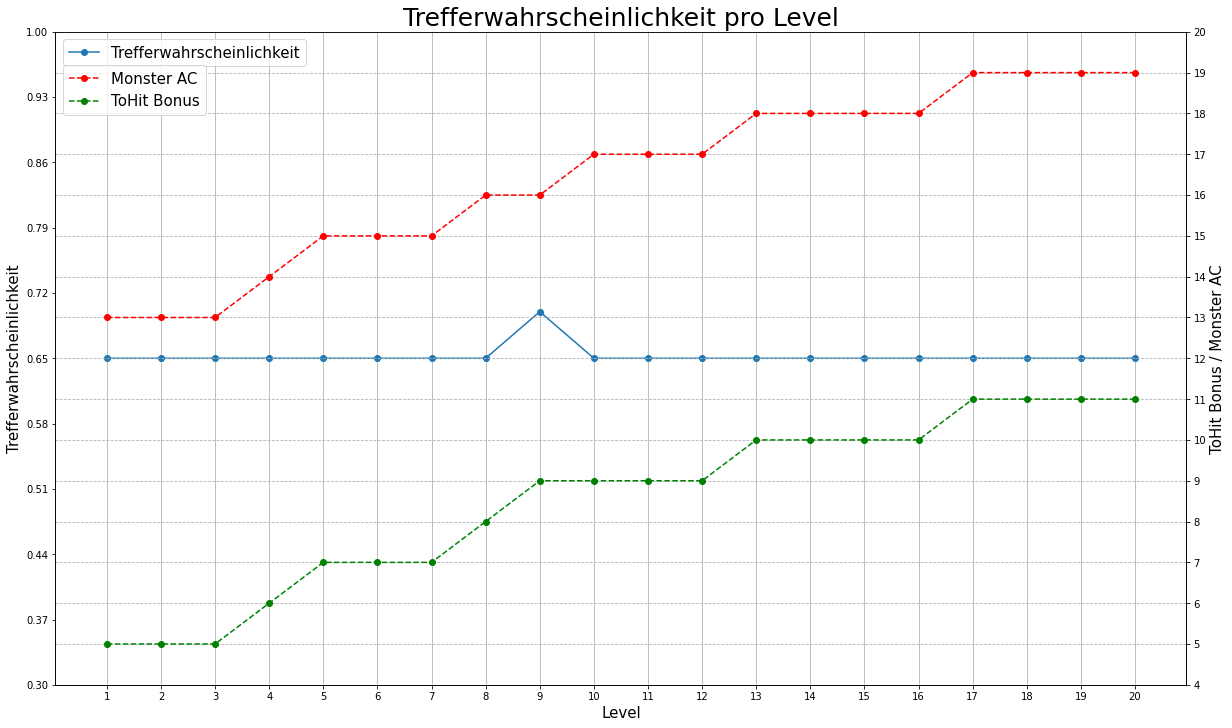

In [5]:
X = tw_perLevel.index
# yerror = list(advDF["mit Advantage"]-advDF["Trefferwahrscheinlichkeit"])
fig, ax1 = plt.subplots(figsize=(17,10), layout="constrained")
ax2 = ax1.twinx()
ax1.plot(X, tw_perLevel["Trefferwahrscheinlichkeit"], "-o", label= "Trefferwahrscheinlichkeit")
ax2.plot(X, tw_perLevel["Monster AC"], "--ro", label= "Monster AC")
ax2.plot(X, tw_perLevel["ToHit Bonus"], "--go", label= "ToHit Bonus")

ax1.grid(True, axis="x")
ax2.grid(True, axis="y", linestyle="--")
ax1.set_xticks(ticks=X)
ax1.set_yticks(ticks=np.linspace(0.3,1.0,11))
ax2.set_yticks(ticks=np.linspace(4,20,17))

ax1.legend(loc="upper left", fontsize=TICKSIZE)
ax2.legend(loc="upper left", bbox_to_anchor=(0.0, 0.96), fontsize=TICKSIZE)

ax1.set_xlabel("Level", fontsize=TICKSIZE)
ax1.set_ylabel("Trefferwahrscheinlichkeit", fontsize=TICKSIZE)
ax2.set_ylabel("ToHit Bonus / Monster AC", fontsize=TICKSIZE)
ax1.set_title("Trefferwahrscheinlichkeit pro Level", fontsize=TITLESIZE)


plt.show()

Man erkennt, dass das Spiel die Monster AC so angepasst hat, dass ein Spieler mit einer 65%igen Trefferwahrscheinlichkeit rechnen kann.

Beispiel:
* Mit Level 4 wird die Monster AC auf 14 erhöht.
* Bei diesem Level gibt es aber auch ein ASI
* Gleich darauf, mit Level 5 steigt die Monster AC erneut, auf 15.
* Gleichzeitig wird aber auch der Proficiency Bonus um 1 erhöht.
* So bleibt die Trefferwahrscheinlichkeit durch alle Level bei 65% (kleine Ausnahme Level 9 - 70%)

## Advantage / Disadvantage Auswertung

PHB S. 173: "Sometimes a special ability or spell tells you that you have advantage or disadvantage [...]. When that happens, you roll a second d20 when you make the roll. Use the higher of the two rolls if you have advantage, and use the lower roll if you have disadvantage."

Aus diese Beschreibung der Mechanik lassen sich folgende Punkte für die Berechnung der Trefferwahrscheinlichkeit mit Advantage/Disadvantage ableiten:

* Bei Advantage wirft man zwei Würfel und nimmt das bessere Ergebnis (bei Disadvantage das schlechtere).
* Das bedeutet, um mit Advantage einen Treffer zu landen muss nur einer der beiden Würfe treffen.
* Wir haben oben die Trefferwahrscheinlichkeit als 1 minus der Wahrscheinlichkeit für einen Misserfolg definiert.
* Daher ist die Wahrscheinlichkeit mit Advantage zu treffen 1 minus der Wahrscheinlichkeit, dass beide Würfe nicht treffen.
    * Z.B. toHit: +10, AC: 13 da würde 3 und höher treffen, bzw. 2 und 1 wären ein Misserfolg:
    * Es gibt insgesamt 400 (20*20) mögliche Kombinationen an Würfelresultaten
    * Davon sind nur 4 ein Misserfolg: 
        * (erster Wurf, zweiter Wurf): (1, 1) (1, 2) (2, 1), (2, 2)
    * Daher ist die Wahrscheinlichkeit eines Misserfolgs 4/400, oder 1%
    * Im Umkehrschluss ist ein Wurf mit +10 toHit mit Advantage gegen eine AC 13 zu 99% erfolgreich
* Das gleiche Prinzip gilt natürlich auch für Disadvantage:
    * Z.B. toHit: +1, AC: 20, eine 19 und 20 würden treffen:
    * Es gibt wieder 400 (20*20) mögliche Kombinationen
    * Davon sind nur 4 ein Erfolg:
        * (19, 19) (19, 20) (20, 19), (20, 20)
    * Daher ist die Wahrscheinlichkeit eines Misserfolgs 396/400, oder 99%
    * Im Umkehrschluss ist ein Wurf mit +1 toHit mit Disadvantage gegen eine AC 20 nur zu 1% erfolgreich

### Formalisierung Trefferwahrscheinlichkeit mit Advantage/Disadvantage

Für einen straight roll haben wir oben formuliert:

$p = 1 - \frac{AC-toHit-1}{20}$

Für einen Treffer mit Advantage:

$p = 1 -(\frac{AC-toHit-1}{20})^2$

Für einen Treffer mit Disadvantage:

$p = (\frac{20-AC-toHit+1}{20})^2$

### Honorable Mention: Trip-Advantage
An dieser Stelle nur erwähnt, aber in weiterer Folge ignoriert, die Möglichkeit des Dreifach-Advantage. Das Regelwerk verbietet mehr als einen Advantage/Disadvantage (PHB S. 173: "If multiple situations affect a roll and each one grants advantage or imposes disadvantage on it, you don't roll more than one additional d20. If two favorable situations grant advantage, for example, you still roll only one additional d20."), es gibt jedoch die Möglichkeit über Feats einen der beiden Würfe zu Wiederholen (z.B. über den Elven Accuracy Feat, oder dem Lucky Feat).

Berechnung wie für Advantage, nur mit 3d20 (8.000 mögliche Kombinationen) - daher:

$p = 1- (\frac{AC-toHit-1}{20})^3$

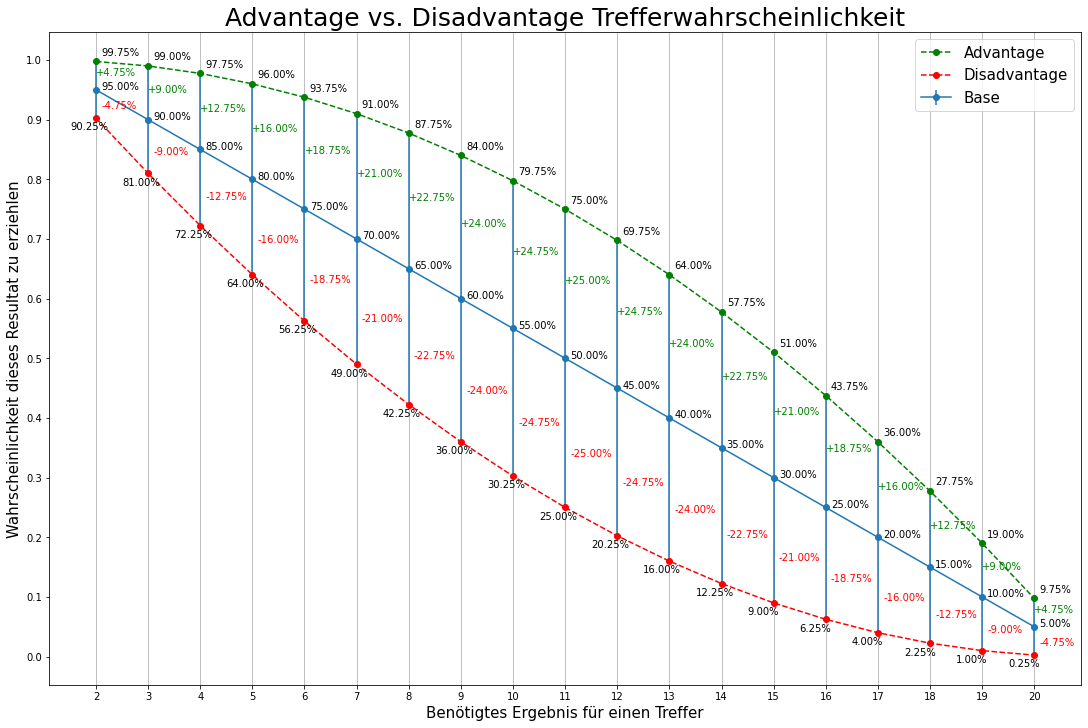

In [6]:
advDF = pd.DataFrame(index=list(range(2,21)))
advDF.index.name = "Benötigtes Ergebnis"

advDF["Trefferwahrscheinlichkeit"] = (1 - (advDF.index-1)/20)
advDF["mit Advantage"] = (1 - ((advDF.index-1)/20)**2)
advDF["mit Disadvantage"] = ((20-advDF.index+1)/20)**2

advDF["Unterschied zu Base"] = advDF["mit Advantage"] - advDF["Trefferwahrscheinlichkeit"]
# advDF["Dadv Unterschied zu Base"] = advDF["mit Disadvantage"] - advDF["Trefferwahrscheinlichkeit"]
advDF["Umrechnung statischer Bonus"] = advDF['Unterschied zu Base']*20 #(*100/5)
advDF

X = advDF.index
yerror = list(advDF["mit Advantage"]-advDF["Trefferwahrscheinlichkeit"])
fig, ax = plt.subplots(figsize=(15,10), layout="constrained")
ax.errorbar(X, y=advDF["Trefferwahrscheinlichkeit"], yerr=yerror, fmt="-o", label= "Base")
ax.plot(X, advDF["mit Advantage"], "--go", label= "Advantage")
ax.plot(X, advDF["mit Disadvantage"], "--ro", label= "Disadvantage")
for x,perc,adv,dadv,diff in zip(X, advDF["Trefferwahrscheinlichkeit"], advDF["mit Advantage"], advDF["mit Disadvantage"], advDF["Unterschied zu Base"]):
    ax.annotate(text=f"{perc:.2%}", xy=(x+0.1, perc))
    ax.annotate(text=f"{adv:.2%}", xy=(x+0.1, adv+0.01))
    ax.annotate(text=f"{dadv:.2%}", xy=(x-0.5, dadv-0.02))
    ax.annotate(text=f"{diff:+.2%}", xy=(x, perc+diff*0.5)).set_color("g")
    ax.annotate(text=f"-{diff:-.2%}", xy=(x+0.1, perc-diff*0.66)).set_color("r")
ax.grid(True, axis="x")
ax.set_xticks(ticks=X)
ax.set_yticks(ticks=np.linspace(0,1,11))
ax.set_xlabel("Benötigtes Ergebnis für einen Treffer", fontsize=TICKSIZE)
ax.set_ylabel("Wahrscheinlichkeit dieses Resultat zu erziehlen", fontsize=TICKSIZE)
ax.set_title("Advantage vs. Disadvantage Trefferwahrscheinlichkeit", fontsize=TITLESIZE)
ax.legend(loc="best", fontsize=TICKSIZE)


plt.show()

### Advantage/Disadvantage per Level

Wir können nun die obrige Graphik der durchschnittlichen Trefferwahrscheinlichkeit um die Trefferwahrscheinlichkeit mit Advantage ergänzen, um zu sehen, ob Advantage eine Auswirkung auf die durchschnittliche Trefferwahrscheinlichkeit pro Level hat.

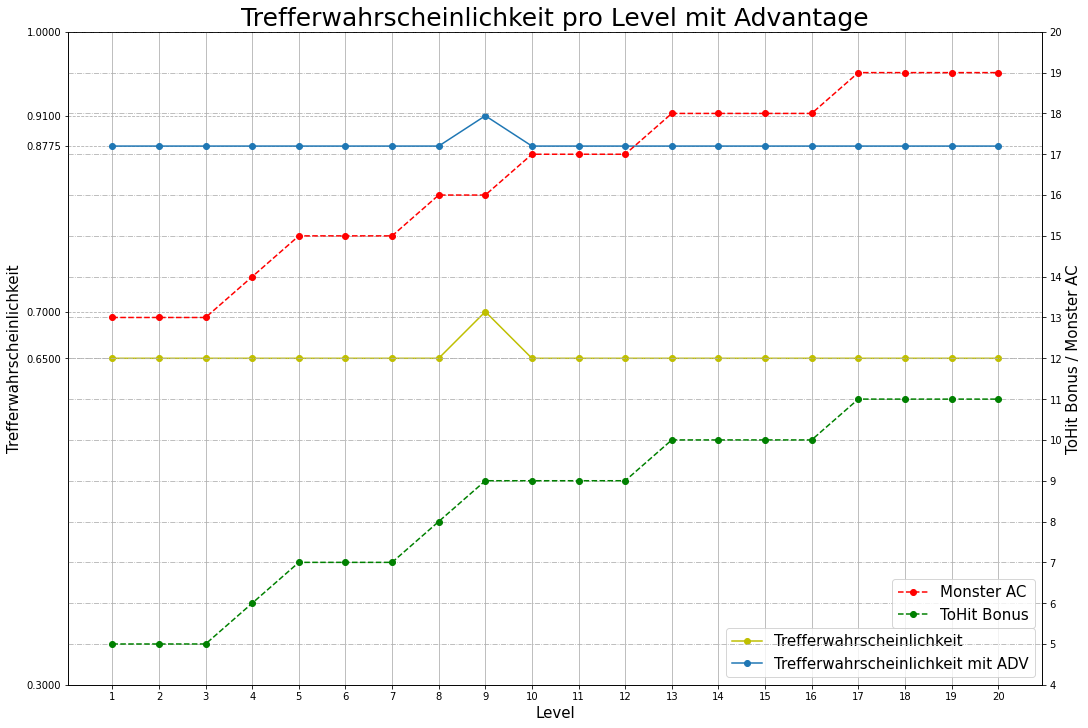

In [7]:
tester_advTW = Hero("Toni Advantage TW", toHitBonus=5)
adv_tw_list = []

for lvl, ac in zip(tw_perLevel.index, tw_perLevel["Monster AC"]):
    pb = math.ceil(lvl/4)+1
    if lvl >= 8:
        tester_advTW.toHitBonus=5+pb
    elif lvl >= 4:
        tester_advTW.toHitBonus=4+pb
    else:
        tester_advTW.toHitBonus=3+pb

    tester_advTW.calcToHitChance(ac, checkAdvantage=True)
    adv_tw_list.append(tester_advTW.chance2Hit)

tw_perLevel["Trefferwahrscheinlichkeit mit ADV"] = adv_tw_list
# tw_perLevel.transpose()


X = tw_perLevel.index
# yerror = list(advDF["mit Advantage"]-advDF["Trefferwahrscheinlichkeit"])
fig, ax1 = plt.subplots(figsize=(15,10), layout="constrained")
ax2 = ax1.twinx()
ax1.plot(X, tw_perLevel["Trefferwahrscheinlichkeit"], "-yo", label= "Trefferwahrscheinlichkeit")
ax1.plot(X, tw_perLevel["Trefferwahrscheinlichkeit mit ADV"], "-o", label= "Trefferwahrscheinlichkeit mit ADV")
ax2.plot(X, tw_perLevel["Monster AC"], "--ro", label= "Monster AC")
ax2.plot(X, tw_perLevel["ToHit Bonus"], "--go", label= "ToHit Bonus")

ax1.grid(True, axis="x")
ax1.grid(True, axis="y", linestyle="--")
ax2.grid(True, axis="y", linestyle="-.")
ax1.set_xticks(ticks=X)
# ax1.set_yticks(ticks=np.linspace(0.3,1.0,7))
ax1.set_yticks(ticks=[0.3, 0.65, 0.7, 0.8775, 0.91, 1.0])
ax2.set_yticks(ticks=np.linspace(4,20,17))

ax1.legend(loc="lower right", fontsize=TICKSIZE)
ax2.legend(loc="lower right", bbox_to_anchor=(1, 0.075), fontsize=TICKSIZE)

ax1.set_xlabel("Level", fontsize=TICKSIZE)
ax1.set_ylabel("Trefferwahrscheinlichkeit", fontsize=TICKSIZE)
ax2.set_ylabel("ToHit Bonus / Monster AC", fontsize=TICKSIZE)
ax1.set_title("Trefferwahrscheinlichkeit pro Level mit Advantage", fontsize=TITLESIZE)


plt.show()

Man erkennt, dass (erwartungsgemäß) die Trefferwahrscheinlichkeit mit Advantage ebenso konstant gehalten wird, wie jene eines "straight rolls".

Die Steigerung entspricht den +22,75%, die auch im vorherigen Plot (Advantage vs. Disadvantage Trefferwahrscheinlichkeit) abgelesen werden können.

In gleicher Weise kann gesehen werden, dass der Peak bei Level 9 mit Advantage flacher ausfällt. Vgl. wieder die Graphik "Advantage vs. Disadvantage Trefferwahrscheinlichkeit", dort sieht man, dass sich die Trefferwahrscheinlichkeit beim straight roll linear um 5% erhöht (von 65% auf 70%). Die Trefferwahrscheinlichkeit mit Advantage erhöht sich jedoch nur um 3,25% (von 87,75% auf 91%).

# Zu erwartender Schaden

Der reine Schaden, der diese Waffe macht. In DnD haben wir 6 unterschiedliche Schadenswürfel:

* d4, d6, d8, d10, d12, 2d6

## Durchschnittliches Würfelergebnis

Der durchschnittliche Wert eines Würfels ist immer die Hälfte der maximalen Würfelzahl ($d_{max}$) +0.5

$\bar{x} = \frac{d_{max}}{2}+0,5$

Das durchschnittliche Würfelergebnis eines d4 ist 2,5.

$\bar{x} = \frac{1+2+3+4}{4} = \frac{10}{4} = 2,5$

Gleiches gilt für jeden Würfel: (d6 = 3,5, d8 = 4,5, d10 = 5,5, d12 = 6,5, 2d6 = 7).

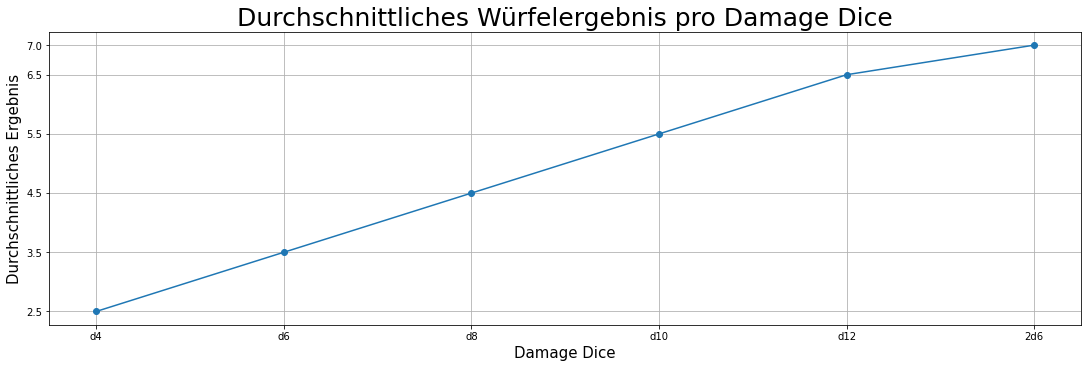

In [8]:
X = ["d4","d6","d8","d10","d12","2d6"]
Y = [2.5,3.5,4.5,5.5,6.5,7]
# yerror = list(advDF["mit Advantage"]-advDF["Trefferwahrscheinlichkeit"])
fig, ax = plt.subplots(figsize=(15,5), layout="constrained")
ax.plot(X, Y, "-o", label="Durchschnittlicher Schaden")
ax.grid(True)
ax.set_yticks(ticks=Y)
ax.set_xlabel("Damage Dice", fontsize=TICKSIZE)
ax.set_ylabel("Durchschnittliches Ergebnis", fontsize=TICKSIZE)
ax.set_title("Durchschnittliches Würfelergebnis pro Damage Dice", fontsize=TITLESIZE)
plt.show()

Man sieht, dass der durchschnittliche Schaden (wie erwartet) linear steigt.

Die Ausnahme ist natürlich der letzte Sprung von d12 auf 2d6, da 2d6 nicht die natürliche Fortsetzung der Reihe, sondern das Verdoppeln des d6 ist.

## Berechnung des zu erwartenden Schadens

Der durchschnittliche Schaden einer Waffe ist aber nur bedingt aussagekräftig, da er nur erreicht werden kann, wenn man 100% seiner Angriffe trifft.

Da das nicht der Fall ist, muss der durchschnittliche Schaden mit der Trefferwahrscheinlichkeit modifiziert werden, um den zu erwartenden Schaden zu ergeben.

$\mu= Trefferwahrscheinlichkeit*durchschnittlicher Schaden$

$\mu = (1 - \frac{AC-toHit-1}{20})*(\frac{d_{max}}{2}+0,5)$

Beispiel:

Wenn man, mit einer Waffe, die durchschnittlich 3,5 Punkte Schaden macht (Damage Dice = d6), in 55% der Fälle trifft (Benötigtes Ergebnis = 10), dann kann man erwarten, mit jedem Angriff, 1,925 Punkte Schaden zu machen.

$\mu = (1 - \frac{10-0-1}{20})*(\frac{6}{2}+0,5) = (1-\frac{9}{20})*3,5 = 0,55*3,5 = 1,925$



## Was ist mit den Crits?

Der zu erwartende Schaden von kritischen Treffern wird auf die gleiche Art wie der "normale" Schaden berechnet. Da bei jedem Angrifswurf die Möglichkeit eines kritischen Treffers besteht, wird der zu erwartende kritische Schaden in die Berechnung des gesamten zu erwartenden Schadens integriert.

Hier angeführt, die veränderten Parameter eines kritischen Treffers:
* Die Chance auf einen kritischen Treffer ($p_{crit}$) ist, normalerweise, 5% (20 auf einem d20)
    * PHB S. 194: "If the d20 roll for an attack is a 20, the attack hits regardless of any modifiers or the target's AC. This is called a critical hit [...].
* Die Würfelanzahl wird verdoppelt (1d6 --> 2d6)
    * PHB S. 196: "When you score a critical hit, you get to roll extra dice for the attack's damage against the target. Roll all of the attack's damage dice twice and add them together. Then add any relevant modifiers as normal."

$\bar{x}_{crit} = 2*(\frac{d_{max}}{2}+0,5)$

* Der kritische Schaden eines Shortswords (1d6 --> 2d6) ist daher 7.
* Bei einem Greatsword (2d6 --> 4d6) ist der kritische Schaden: 14
* Der zu erwartende kritische Schaden eines Kurzschwerts ist 0,35
    * $\mu_{crit} = \bar{x}_{crit}*p_{crit} = 7 * 0,05 = 0,35$
* Diese 0,35 werden nun zu dem "normalen" erwartenden Schaden addiert (s.o. 1,925).
    * $\mu_{base} + \mu_{crit} = 1,925+0,35=2,275$
* Somit ist der tatsächlich zu erwartende Schaden 2,275

# Welchen Unterschied macht die Wahl der Waffe?

Nachdem nun die Ausgangsparameter geklärt sind, könnnen einige Spielmechaniken hinsichtlich des Zu erwartenden Schadens analysiert werden.

Die erste Fragestellung betrifft die Wahl der Waffe. Welchen Unterschied macht es mit den einzelnen Waffentypen zuzuschlagen.

Da der Fokus auf dem Damage Dice liegt, wird kein Modifier angenommen (+0) und eine Monster Armour Class von 8 - um die vom Spiel vorgesehene 65% Trefferwahrscheinlichkeit zu erreichen.

In [67]:
monsterAC = 8
modifier = 0

d4_toni = Hero("d4 Toni", modifier)
d4_toni.addDamageSource(DamageSource("d4", damageDice=Dice(1,4), diceAmount=1))
d4_toni.addDamageSource(DamageSource("Modifier", staticBonus=modifier))
d4_toni.calcToHitChance(monsterAC)
d4_toni.damageCalculator()

d6_toni = Hero("d6 Toni", modifier)
d6_toni.addDamageSource(DamageSource("d6", damageDice=Dice(1,6), diceAmount=1))
d6_toni.addDamageSource(DamageSource("Modifier", staticBonus=modifier))
d6_toni.calcToHitChance(monsterAC)
d6_toni.damageCalculator()

d8_toni = Hero("d8 Toni", modifier)
d8_toni.addDamageSource(DamageSource("d8", damageDice=Dice(1,8), diceAmount=1))
d8_toni.addDamageSource(DamageSource("Modifier", staticBonus=modifier))
d8_toni.calcToHitChance(monsterAC)
d8_toni.damageCalculator()

d10_toni = Hero("d10 Toni", modifier)
d10_toni.addDamageSource(DamageSource("d10", damageDice=Dice(1,10), diceAmount=1))
d10_toni.addDamageSource(DamageSource("Modifier", staticBonus=modifier))
d10_toni.calcToHitChance(monsterAC)
d10_toni.damageCalculator()

d12_toni = Hero("d12 Toni", modifier)
d12_toni.addDamageSource(DamageSource("d12", damageDice=Dice(1,12), diceAmount=1))
d12_toni.addDamageSource(DamageSource("Modifier", staticBonus=modifier))
d12_toni.calcToHitChance(monsterAC)
d12_toni.damageCalculator()

toni_2d6 = Hero("2d6 Toni", modifier)
toni_2d6.addDamageSource(DamageSource("2d6", damageDice=Dice(1,6), diceAmount=2))
toni_2d6.addDamageSource(DamageSource("Modifier", staticBonus=modifier))
toni_2d6.calcToHitChance(monsterAC)
toni_2d6.damageCalculator()


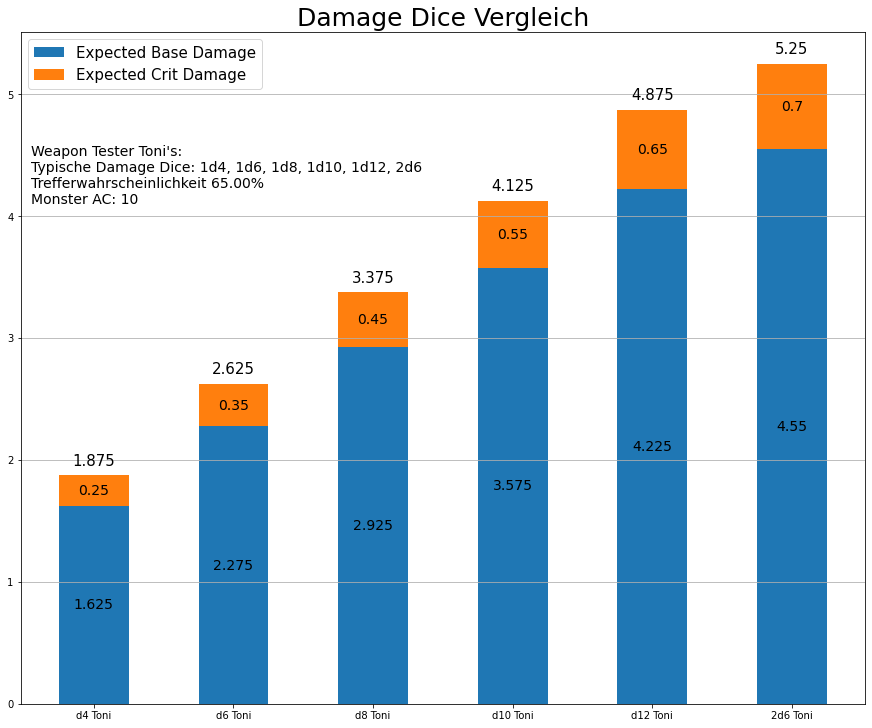

In [68]:
weapon_dictionary = {
    "1d4":(1, dice_dictionary["d4"]),
    "1d6":(1, dice_dictionary["d6"]),
    "1d8":(1, dice_dictionary["d8"]),
    "1d10":(1, dice_dictionary["d10"]),
    "1d12":(1, dice_dictionary["d12"]),
    "2d6":(2, dice_dictionary["d6"]),
}
list_of_weapons = list(weapon_dictionary.keys())

graph_text = str(f"Weapon Tester Toni's:"
                 f"\nTypische Damage Dice: {', '.join(list_of_weapons)}"+
                 f"\nTrefferwahrscheinlichkeit {d4_toni.chance2Hit:.2%}"+
                 f"\nMonster AC: 10"
                 )

weapon_testing_dict = {
    d4_toni.name:list(d4_toni.heroValues.values()),
    d6_toni.name:list(d6_toni.heroValues.values()),
    d8_toni.name:list(d8_toni.heroValues.values()),
    d10_toni.name:list(d10_toni.heroValues.values()),
    d12_toni.name:list(d12_toni.heroValues.values()),
    toni_2d6.name:list(toni_2d6.heroValues.values()),
}

fig, ax, plot_dict = stacked_bar_plot_from_dict(weapon_testing_dict, "Damage Dice Vergleich")
ax.grid(True, axis="y")
ax.text(x=-0.45, y=4.1, s=graph_text, fontdict={"size":14})
plt.show()

Was hier zu sehen ist:
* Der durchschnittliche Schaden eines d4 = 2,5. Eines d6 = 3,5 ... 
    * Der durchschnittliche Schaden erhöht sich also immer um 1.
* Diese Steigerung wird um die Trefferwahrscheinlichkeit modifiziert, daher steigt der Schaden um +0,65
* Der durchschnittliche kritische Schaden eines d4 = 5. Eines d6 = 7 ...
    * Dieser Schaden Schaden steigt um 2.
* Auch hier die +2 Steigerung wird um die Chance auf einen kritischen Treffer modifiziert (0,05), das ergibt die zu sehende Steigerung von +0,1
* Zusammenaddiert ergibt sich also für jede Waffenstufe ein Plus von 0,75.
* Große Ausnahme ist natürlich die 2d6, die bereits angesprochene Verdoppelung der Werte des d6.
    * Daher ist der Unterschied im zu erwartenden Schaden zum d12: 0,375 (+0,325 für regulär to Hit bzw. +0,05 für den kritischen Schaden).
    * Somit ist der Unterschied zwischen d12 und 2d6 genau die Hälfte vom Unterschied der anderen Waffen.
* Würde sich der Modifier erhöhen würde der Unterschied des zu erwartenden Schadens pro Damage Dice parallel zur Trefferwahrscheinlichkeit um 0,05 pro Punkt zunehmen.
    * D.h. bei einem +2 Modifier wäre die neue Trefferwahrscheinlichkeit 75% und daher der Unterschied im zu erwartenden Schaden +0,85
    * Derkritische Schaden verändert sich zwar, das Verhältnis untereinander bleibt aber immer gleich (+0,1), da der Modifier nicht die Chance auf einen kritischen Treffer erhöht.

## Erwarteter Schaden per Monster AC

Mit Zuwachs der Monster Armour Class nimmt die Trefferwahrscheinlichkeit ab (um 0,05 für jeden Punkt Steigerung).

Hier soll nun herausgefunden werden wieviel Einfluss das auf den zu erwartenden Schaden hat.

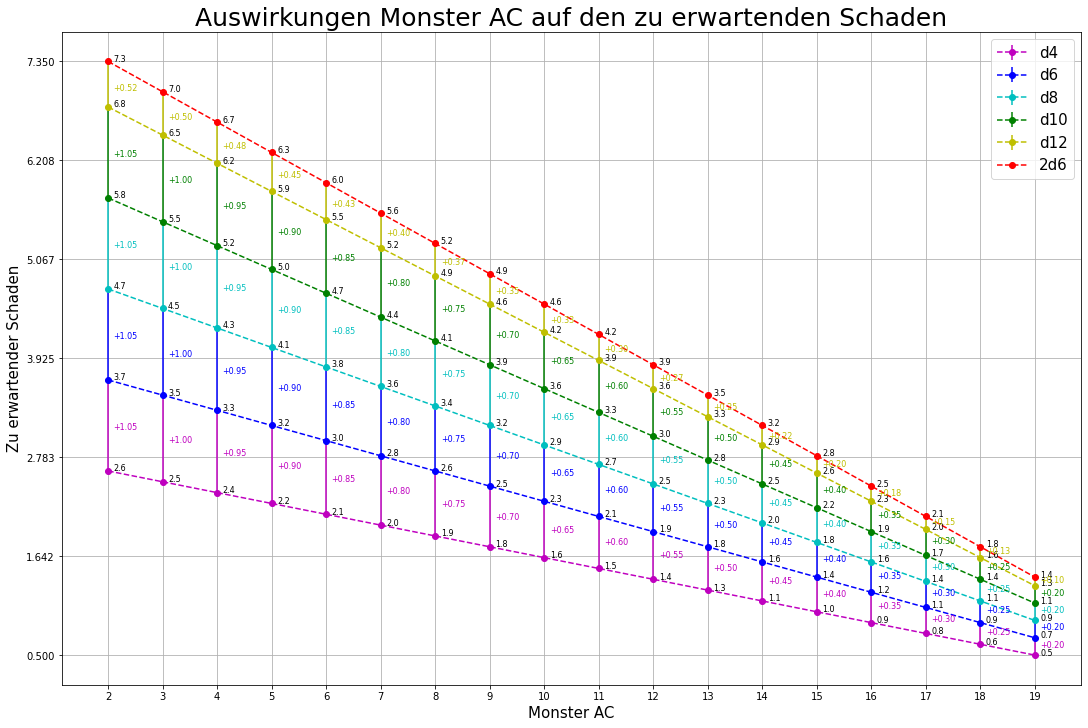

In [73]:
checkAC_DF = pd.DataFrame(index=list(range(2,20)) ,columns=["d4", "d6", "d8", "d10", "d12", "2d6"])
checkAC_DF.index.name = "Monster AC"
for ac in checkAC_DF.index:
    d4_toni.calcToHitChance(monsterAC=ac)
    d4_toni.damageCalculator()
    d6_toni.calcToHitChance(monsterAC=ac)
    d6_toni.damageCalculator()
    d8_toni.calcToHitChance(monsterAC=ac)
    d8_toni.damageCalculator()
    d10_toni.calcToHitChance(monsterAC=ac)
    d10_toni.damageCalculator()
    d12_toni.calcToHitChance(monsterAC=ac)
    d12_toni.damageCalculator()
    toni_2d6.calcToHitChance(monsterAC=ac)
    toni_2d6.damageCalculator()

    checkAC_DF.loc[ac] = [sum(d4_toni.expected_damage.values()), 
                          sum(d6_toni.expected_damage.values()), 
                          sum(d8_toni.expected_damage.values()),
                          sum(d10_toni.expected_damage.values()),
                          sum(d12_toni.expected_damage.values()),
                          sum(toni_2d6.expected_damage.values()),                          
                          ]

graph_DF = checkAC_DF.copy()
checkAC_DF = checkAC_DF.transpose()
checkAC_DF["Unterschied"] = checkAC_DF[19]-checkAC_DF[18]
# checkAC_DF

X = list(graph_DF.index)
d4_d6 = list(graph_DF["d6"]-graph_DF["d4"])
d6_d8 = list(graph_DF["d8"]-graph_DF["d6"])
d8_d10 = list(graph_DF["d10"]-graph_DF["d8"])
d10_d12 = list(graph_DF["d12"]-graph_DF["d10"])
d12_2d6 = list(graph_DF["2d6"]-graph_DF["d12"])
zeros = [0]*18

fig, ax = plt.subplots(figsize=(15,10), layout="constrained")
ax.errorbar(X, y=graph_DF["d4"], yerr=[zeros, d4_d6], fmt="--mo", label= "d4")
ax.errorbar(X, y=graph_DF["d6"], yerr=[zeros, d6_d8], fmt="--bo", label= "d6")
ax.errorbar(X, y=graph_DF["d8"], yerr=[zeros, d8_d10], fmt="--co", label= "d8")
ax.errorbar(X, y=graph_DF["d10"], yerr=[zeros, d10_d12], fmt="--go", label= "d10")
ax.errorbar(X, y=graph_DF["d12"], yerr=[zeros, d12_2d6], fmt="--yo", label= "d12")
ax.errorbar(X, y=graph_DF["2d6"], yerr=None, fmt="--ro", label= "2d6")

annotate_zip = zip(X,
                   graph_DF["d4"],
                   d4_d6,
                   graph_DF["d6"],
                   d6_d8,
                   graph_DF["d8"],
                   d8_d10,
                   graph_DF["d10"],
                   d10_d12,
                   graph_DF["d12"],
                   d12_2d6,
                   graph_DF["2d6"],
)

annotate_fontsize=8

for x,d4,diff_d4,d6,diff_d6,d8,diff_d8,d10,diff_d10,d12,diff_d12,twod6 in annotate_zip:
    ax.annotate(text=f"{d4:.1f}", xy=(x+0.1, d4),fontsize=annotate_fontsize)
    ax.annotate(text=f"{d6:.1f}", xy=(x+0.1, d6),fontsize=annotate_fontsize)
    ax.annotate(text=f"{d8:.1f}", xy=(x+0.1, d8),fontsize=annotate_fontsize)
    ax.annotate(text=f"{d10:.1f}", xy=(x+0.1, d10),fontsize=annotate_fontsize)
    ax.annotate(text=f"{d12:.1f}", xy=(x+0.1, d12),fontsize=annotate_fontsize)
    ax.annotate(text=f"{twod6:.1f}", xy=(x+0.1, twod6),fontsize=annotate_fontsize)

    ax.annotate(text=f"{diff_d4:+.2f}", xy=(x+0.1, d4+diff_d4*0.45),fontsize=annotate_fontsize).set_color("m")
    ax.annotate(text=f"{diff_d6:+.2f}", xy=(x+0.1, d6+diff_d6*0.45),fontsize=annotate_fontsize).set_color("b")
    ax.annotate(text=f"{diff_d8:+.2f}", xy=(x+0.1, d8+diff_d8*0.45),fontsize=annotate_fontsize).set_color("c")
    ax.annotate(text=f"{diff_d10:+.2f}", xy=(x+0.1, d10+diff_d10*0.45),fontsize=annotate_fontsize).set_color("g")
    ax.annotate(text=f"{diff_d12:+.2f}", xy=(x+0.1, d12+diff_d12*0.35),fontsize=annotate_fontsize).set_color("y")

ax.grid(True, axis="both")
ax.set_xticks(ticks=X)
ax.set_yticks(ticks=np.linspace(graph_DF.min().min(),graph_DF.max().max(),7))

ax.legend(loc="best", fontsize=TICKSIZE)

ax.set_xlabel("Monster AC", fontsize=TICKSIZE)
ax.set_ylabel("Zu erwartender Schaden", fontsize=TICKSIZE)
ax.set_title("Auswirkungen Monster AC auf den zu erwartenden Schaden", fontsize=TITLESIZE)

plt.show()

In [75]:
# checkAC_DF["Unterschied"]

Was man hier sieht:

* Die Unterschiede im zu erwartenden Schaden werden mit zunehmender Monster AC geringer.
    * Der Schaden eines d4 fällt um 0.125 Punkte pro Punkt in Monster AC
    * Bei einem d6 fällt der Schaden um 0.175
    * d8: -0.225
    * d10: -0.275
    * d12: -0.325
    * 2d6: -0.35
* Bei einer hohen Trefferwahrscheinlichkeit macht es einen großen Unterschied welche Waffe man verwendet.
    * Zur Erinnerung bei einer 100%igen Trefferwahrscheinlichkeit würde der zu erwartende Schaden dem durchschnittlichen Schaden entsprechen.
    * Dann wäre die Steigerung +1, bzw. +1,1 wenn man den zu erwartenden kritischen Schaden miteinberechnet (s.o.)
* Hingegen wird bei einer abnehmenden Trefferwahrscheinlichkeit der durchschnittliche Waffenschaden weniger relevant.
    * Vulgo: Es ist egal mit welcher Waffe ich nicht treffe.
* Natürlich sind auch hier die Unterschiede zwischen den Waffenarten gleich - mit Ausnahme d12 vs. 2d6 (s.o.).

## Vergleich Der Auswirkung Advantage auf den Waffenschaden

In [13]:
# kommt noch

# Ability Score Improvement Auswirkungen

Hier soll herausgefunden werden, welchen Unterschied eine Erhöhung eines Attributes auf den zu erwartenden Schaden hat?

Im Reegelfall kann ein Held alle vier Level eines seiner Attribute erhöhen (Ability Score Improvement - ASI).

Dadurch erhöht sich die Trefferwahrscheinlichkeit, aber auch der Schaden wird um einen Punkt erhöht.

PHB S. 196: "When attacking with a weapon, you add your ability modifier—the same modifier used for the attack roll to the damage."

Verglichen wird der Standard Held (0 Modifier vs. AC 8 für 65% Trefferwahrscheinlichkeit) mit dem erhöhten Wert (+1 Modifier für 70% Trefferwahrscheinlichkeit und zusätzlichen +1 auf Damge). Als Waffe wurde in beiden Fällen ein Longsword (1d8 Damage Dice) gewählt.

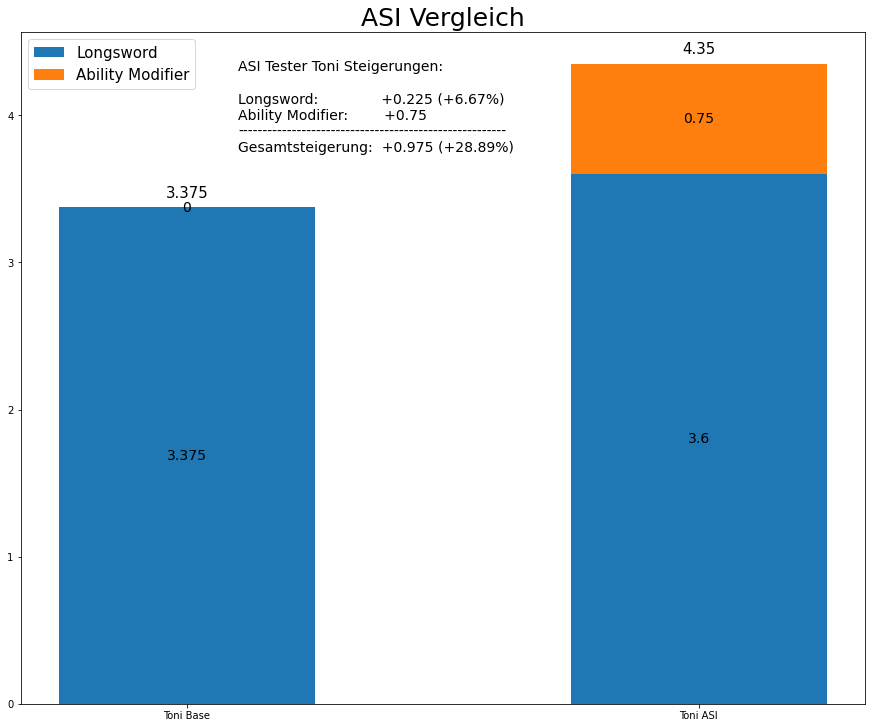

In [81]:
asi_toni_base = Hero("Toni Base", 0)
asi_toni_base.addDamageSource(DamageSource("Longsword", damageDice=Dice(1,8), diceAmount=1))
asi_toni_base.addDamageSource(DamageSource("Ability Modifier", staticBonus=0))
asi_toni_base.calcToHitChance(8)
asi_toni_base.damageCalculator()

asi_toni = Hero("Toni ASI", 1)
asi_toni.addDamageSource(DamageSource("Longsword", damageDice=Dice(1,8), diceAmount=1))
asi_toni.addDamageSource(DamageSource("Ability Modifier", staticBonus=1))
asi_toni.calcToHitChance(8)
asi_toni.damageCalculator()

# asi_toni_base.show_hero_stats(full=True)
# print("="*20)
# asi_toni.show_hero_stats(full=True)

growth_dict = {
    "Gesamt exp Damage":calc_growth(asi_toni_base.heroValues["Expected Damage"],asi_toni.heroValues["Expected Damage"]),
    "Longsword":calc_growth(asi_toni_base.expected_damage["Longsword"], asi_toni.expected_damage["Longsword"]),
    "Ability Modifier":[asi_toni.expected_damage["Ability Modifier"], 0.0]
}
growth_dict

graph_text = str(
    f"ASI Tester Toni Steigerungen:"+
    "\n"
    "\nLongsword:"+" "*14+ f"{growth_dict['Longsword'][0]:+.3f} ({growth_dict['Longsword'][1]:+.2%})"+
    "\nAbility Modifier:"+" "*8+f"{growth_dict['Ability Modifier'][0]:+.2f}"+
    "\n"+"-"*55+
    "\nGesamtsteigerung:"+" "*2+f"{growth_dict['Gesamt exp Damage'][0]:+.3f} ({growth_dict['Gesamt exp Damage'][1]:+.2%})"
    )

plot_dict = {
    "Longsword":[asi_toni_base.expected_damage["Longsword"],asi_toni.expected_damage["Longsword"]],
    "Ability Modifier":[asi_toni_base.expected_damage["Ability Modifier"],asi_toni.expected_damage["Ability Modifier"]],
}

fig, ax = draw_stacked_bar_plot(plot_dict, labels=[asi_toni_base.name, asi_toni.name], title="ASI Vergleich")
ax.text(x=0.1, y=3.75, s=graph_text, fontdict={"size":14})

plt.show()

Was ist zu sehen:
* Die erhöhte Trefferwahrscheinlichkeit und der zusätzliche +1 Bonus auf den Schaden erhöhen den zu erwartenden Schaden der Waffe um 0,975 (+28.89%)
* Davon entfallen 0,75 auf den +1 statischen +1 Damage Bonus (0,7 regulärer Schaden und 0,05 für den kritischen Schaden)
* Außerdem wird der Schaden des Langschwerts um 0,225 erhöht (4,5 durchschnittlicher Schaden mal der um 0,05 erhöhten Trefferwahrscheinlichkeit)

# Was ist besser? Ein +2 Schwert, oder Flame Tongue Sword

Zum Vergleich stehen:
* Ein Flame Tongue Longsword mit zusätzlichen 2d6 fire damage
* Ein +2 Longsword

## Punkte zu bedenken
* Beide werden vom Spiel als "rare" eingestuft.
* 2d6 fire Damage sind im Schnitt 7 Punkte Damage
* Das +2 Schwert hat "nur" +2 - aber auch ein +2 auf to Hit
    * Kann das +2 to Hit für den Unterschied im Damage ausmachen?

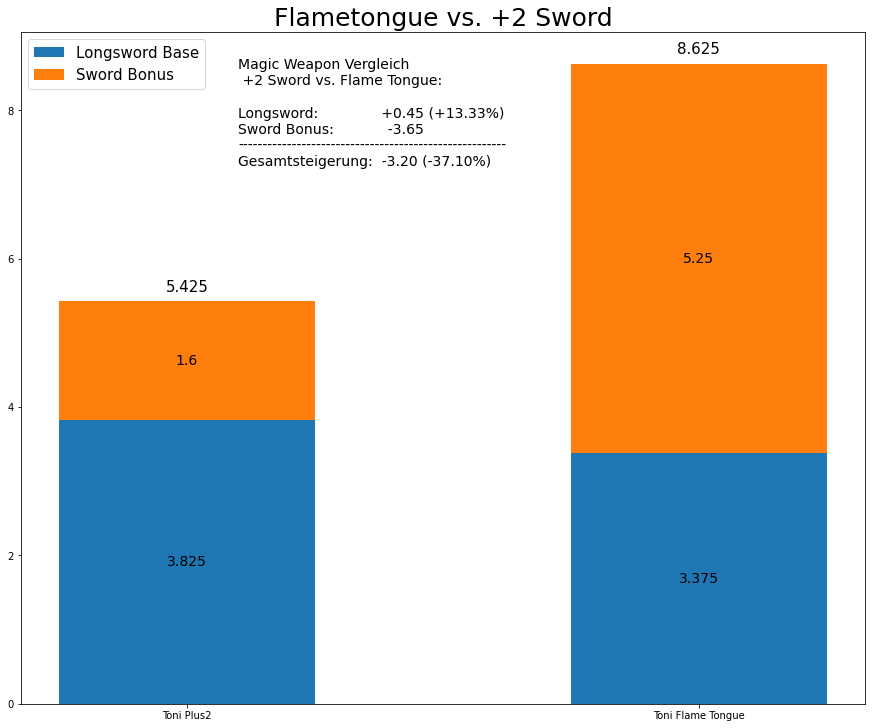

In [106]:
plus2_toni = Hero("Toni Plus2", 2)
plus2_toni.addDamageSource(DamageSource("Longsword", damageDice=Dice(1,8), diceAmount=1))
plus2_toni.addDamageSource(DamageSource("Sword Dmg Bonus", staticBonus=2))
plus2_toni.calcToHitChance(monsterAC=8)
plus2_toni.damageCalculator()

flameTongue_toni = Hero("Toni Flame Tongue", 0)
flameTongue_toni.addDamageSource(DamageSource("Longsword", damageDice=Dice(1,8), diceAmount=1))
flameTongue_toni.addDamageSource(DamageSource("Flame Tongue", damageDice=Dice(1,6), diceAmount=2))
flameTongue_toni.calcToHitChance(monsterAC=8)
flameTongue_toni.damageCalculator()

# plus2_toni.show_hero_stats(full=True)
# print("--------------------")
# flameTongue_toni.show_hero_stats(full=True)

growth_dict = {
    "Gesamt exp Damage":calc_growth(flameTongue_toni.heroValues["Expected Damage"],plus2_toni.heroValues["Expected Damage"]),
    "Longsword":calc_growth(flameTongue_toni.expected_damage["Longsword"], plus2_toni.expected_damage["Longsword"]),
    "Sword Bonus":calc_growth(flameTongue_toni.expected_damage["Flame Tongue"], plus2_toni.expected_damage["Sword Dmg Bonus"]),
    # "Ability Modifier":[asi_toni.expected_damage["Ability Modifier"], 0.0]
}
growth_dict

graph_text = str(
    f"Magic Weapon Vergleich\n +2 Sword vs. Flame Tongue:"+
    "\n"
    "\nLongsword:"+" "*14+ f"{growth_dict['Longsword'][0]:+.2f} ({growth_dict['Longsword'][1]:+.2%})"+
    "\nSword Bonus:"+" "*12+f"{growth_dict['Sword Bonus'][0]:+.2f}"+
    "\n"+"-"*55+
    "\nGesamtsteigerung:"+" "*2+f"{growth_dict['Gesamt exp Damage'][0]:+.2f} ({growth_dict['Gesamt exp Damage'][1]:+.2%})"
    )


plot_dict = {
    "Longsword Base":[plus2_toni.expected_damage["Longsword"],flameTongue_toni.expected_damage["Longsword"]],
    "Sword Bonus":[plus2_toni.expected_damage["Sword Dmg Bonus"],flameTongue_toni.expected_damage["Flame Tongue"]],

}

fig, ax = draw_stacked_bar_plot(plot_dict, labels=[plus2_toni.name, flameTongue_toni.name], title="Flametongue vs. +2 Sword")
ax.text(x=0.1, y=7.25, s=graph_text, fontdict={"size":14})

plt.show()

Was man sieht:
* Es gibt einen deutlichen Unterschied von 3,2 Punkten beim zu erwarten Schaden für das Flame Tongue Longsword.
* Die um 10% erhöhte Trefferwahrscheinlichkeit beim der Grundwaffe führt zu einer Erhöhung des zu erwartenden Schadens um 0,45.
* Dies kann jedoch nicht den großen Unterschied durch die 2d6 zusätzlichen Schaden des Flame Tongue Schwerts kompensieren.
* Wodurch im Gesamtvergleich das Flame Tongue Schwert um 37,10% besser abschneidet.

## Zu erwartender Schaden nach AC

In [17]:
magicItem_DF = pd.DataFrame(index=list(range(2,23)) ,columns=["Flame Tongue", "+2 Sword"])
magicItem_DF.index.name = "Monster AC"
for ac in magicItem_DF.index:
    plus2_toni.calcToHitChance(monsterAC=ac)
    plus2_toni.damageCalculator()
    flameTongue_toni.calcToHitChance(monsterAC=ac)
    flameTongue_toni.damageCalculator()

    magicItem_DF.loc[ac] = [sum(flameTongue_toni.expected_damage.values()), sum(plus2_toni.expected_damage.values())]

magicItem_DF["Unterschied"] = magicItem_DF["Flame Tongue"]-magicItem_DF["+2 Sword"]

magicItem_DF.transpose()

Monster AC,2,3,4,5,6,7,8,9,10,11,...,13,14,15,16,17,18,19,20,21,22
Flame Tongue,15.075,14.35,13.625,12.9,12.175,11.45,10.725,10.0,9.275,8.55,...,7.1,6.375,5.65,4.925,4.2,3.475,2.75,1.3,1.3,1.3
+2 Sword,9.725,9.725,9.725,9.25,8.775,8.3,7.825,7.35,6.875,6.4,...,5.45,4.975,4.5,4.025,3.55,3.075,2.6,2.125,1.65,0.7
Unterschied,5.35,4.625,3.9,3.65,3.4,3.15,2.9,2.65,2.4,2.15,...,1.65,1.4,1.15,0.9,0.65,0.4,0.15,-0.825,-0.35,0.6


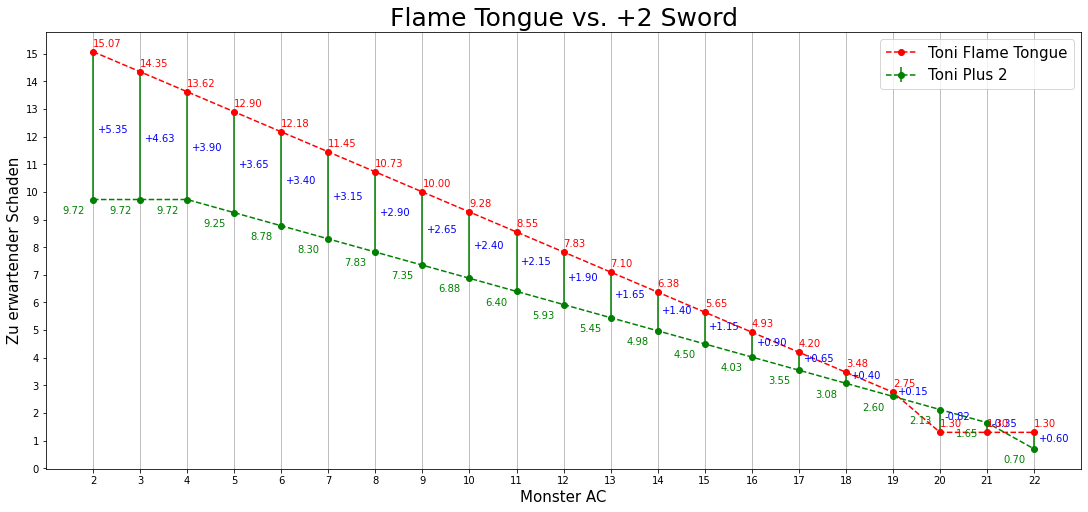

In [18]:
X = magicItem_DF.index
TICKSIZE = 15
TITLESIZE = 25

yerror = list(magicItem_DF["Flame Tongue"]-magicItem_DF["+2 Sword"])
fig, ax = plt.subplots(figsize=(15,7), layout="constrained")
ax.errorbar(X, y=magicItem_DF["+2 Sword"], yerr=[[0]*len(magicItem_DF.index),yerror], fmt="--go", label= "Toni Plus 2")
ax.plot(X, magicItem_DF["Flame Tongue"], "--ro", label= "Toni Flame Tongue")
for x,diff,plus2,ft in zip(X, magicItem_DF["Unterschied"], magicItem_DF["+2 Sword"], magicItem_DF["Flame Tongue"]):
    ax.annotate(text=f"{diff:+.2f}", xy=(x+0.1, plus2+diff*0.45)).set_color("b")
    ax.annotate(text=f"{plus2:.2f}", xy=(x-0.66, plus2-0.5)).set_color("g")
    ax.annotate(text=f"{ft:.2f}", xy=(x, ft+0.2)).set_color("r")
ax.grid(True, axis="x")
ax.set_xticks(ticks=X)
ax.set_yticks(ticks=range(16))
ax.set_xlabel("Monster AC", fontsize=TICKSIZE)
ax.set_ylabel("Zu erwartender Schaden", fontsize=TICKSIZE)
ax.set_title("Flame Tongue vs. +2 Sword", fontsize=TITLESIZE)
ax.legend(loc="best", fontsize=TICKSIZE)

plt.show()

# Analyse der Fighting Styles

## Archery
You gain a +2 bonus to attack rolls you make with ranged weapons.


In [19]:
archery_toni = Hero("Toni Archer", 2)
archery_toni.addDamageSource(DamageSource("Longbow", damageDice=Dice(1,8), diceAmount=1))
archery_toni.addDamageSource(DamageSource("Ability Modifier", staticBonus=2))
archery_toni.calcToHitChance(monsterAC=10)
archery_toni.damageCalculator()
archery_toni.show_hero_stats(full=True)

Helden Name: Toni Archer
ToHit-Bonus: +2
Trefferwahrscheinlichkeit: 0.65
Zu erwartender Schaden: 4.78
----------
Detailaufschlüsselung:
  * Longbow
      Zu erwartender Schaden: 3.375000000000001
      Base Damage: 4.5
      Crit Damage: 9.0
  * Ability Modifier
      Zu erwartender Schaden: 1.4000000000000001
      Base Damage: 2
      Crit Damage: 2


## Dueling
When you are wielding a melee weapon in one hand and no other weapons, you gain a +2 bonus to damage rolls with that weapon.


In [20]:
dueling_toni = Hero("Toni Duelist", 0)
dueling_toni.addDamageSource(DamageSource("Longsword", damageDice=Dice(1,8), diceAmount=1))
dueling_toni.addDamageSource(DamageSource("Dueling FS", staticBonus=2))
dueling_toni.addDamageSource(DamageSource("Ability Modifier", staticBonus=2))
dueling_toni.calcToHitChance(monsterAC=10)
dueling_toni.damageCalculator()
dueling_toni.show_hero_stats(full=True)


Helden Name: Toni Duelist
ToHit-Bonus: +0
Trefferwahrscheinlichkeit: 0.55
Zu erwartender Schaden: 5.33
----------
Detailaufschlüsselung:
  * Longsword
      Zu erwartender Schaden: 2.9250000000000007
      Base Damage: 4.5
      Crit Damage: 9.0
  * Dueling FS
      Zu erwartender Schaden: 1.2000000000000002
      Base Damage: 2
      Crit Damage: 2
  * Ability Modifier
      Zu erwartender Schaden: 1.2000000000000002
      Base Damage: 2
      Crit Damage: 2


## Great Weapon Fighting
When you roll a 1 or 2 on a damage die for an attack you make with a melee weapon that you are wielding with two hands, you can reroll the die and must use the new roll, even if the new roll is a 1 or a 2. The weapon must have the two-handed or versatile property for you to gain this benefit.

Die Idee des GWF ist, dass bei einer 1, oder 2 dieses Ergebnis mit einem neuen Wurf ersetzt wird.
* Unser Standard Array für einen d6 ist [1,2,3,4,5,6] = Durchschnitt = 3,5
* Wird bei einem GWF 1, oder 2 mit einem anderen Wurf ersetzt, wird 1, oder 2 mit dem durchschnitt des neuen Wurfs ersetzt
* Daher ist das angepasste Array: [3.5,3.5,3,4,5,6], Durchschnitt = 4,1667


In [21]:
gwf_toni = Hero("Toni Great Weapon", 0)

gwf_d6 = Dice(1,6)
gwf_d6.dice = np.array([3.5,3.5,3,4,5,6])

gwf_d10 = Dice(1,10)
gwf_d10.dice = np.array([5.5,5.5,3,4,5,6,7,8,9,10])

gwf_d12 = Dice(1,12)
gwf_d12.dice = np.array([6.5,6.5,3,4,5,6,7,8,9,10,11,12])

gwf_toni.addDamageSource(DamageSource("Greatsword", damageDice=gwf_d6, diceAmount=2))
gwf_toni.addDamageSource(DamageSource("Ability Modifier", staticBonus=2))
gwf_toni.calcToHitChance(monsterAC=10)
gwf_toni.damageCalculator()
gwf_toni.show_hero_stats(full=True)


Helden Name: Toni Great Weapon
ToHit-Bonus: +0
Trefferwahrscheinlichkeit: 0.55
Zu erwartender Schaden: 6.62
----------
Detailaufschlüsselung:
  * Greatsword
      Zu erwartender Schaden: 5.416666666666668
      Base Damage: 8.333333333333334
      Crit Damage: 16.666666666666668
  * Ability Modifier
      Zu erwartender Schaden: 1.2000000000000002
      Base Damage: 2
      Crit Damage: 2


## Two-Weapon Fighting
When you engage in two-weapon fighting, you can add your ability modifier to the damage of the second attack.

In [22]:
twoWeapon_toni = Hero("Toni Double Sword", 0)
twoWeapon_toni.addDamageSource(DamageSource("Shortsword", damageDice=Dice(1,6), diceAmount=1))
twoWeapon_toni.addDamageSource(DamageSource("Ability Modifier", staticBonus=2))
twoWeapon_toni.addDamageSource(DamageSource("Shortsword_offHand", damageDice=Dice(1,6), diceAmount=1))
twoWeapon_toni.addDamageSource(DamageSource("Ability Modifier_offHand", staticBonus=2))
twoWeapon_toni.calcToHitChance(monsterAC=10)
twoWeapon_toni.damageCalculator()
twoWeapon_toni.show_hero_stats(full=True)


Helden Name: Toni Double Sword
ToHit-Bonus: +0
Trefferwahrscheinlichkeit: 0.55
Zu erwartender Schaden: 6.95
----------
Detailaufschlüsselung:
  * Shortsword
      Zu erwartender Schaden: 2.2750000000000004
      Base Damage: 3.5
      Crit Damage: 7.0
  * Ability Modifier
      Zu erwartender Schaden: 1.2000000000000002
      Base Damage: 2
      Crit Damage: 2
  * Shortsword_offHand
      Zu erwartender Schaden: 2.2750000000000004
      Base Damage: 3.5
      Crit Damage: 7.0
  * Ability Modifier_offHand
      Zu erwartender Schaden: 1.2000000000000002
      Base Damage: 2
      Crit Damage: 2


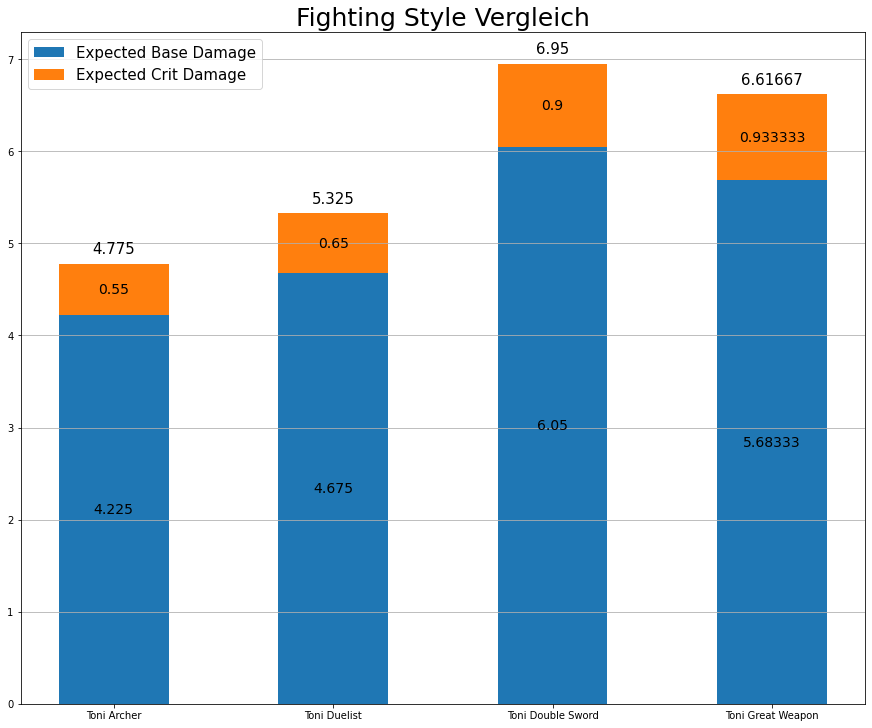

In [23]:
fs_testing_dict = {
    archery_toni.name:list(archery_toni.heroValues.values()),
    dueling_toni.name:list(dueling_toni.heroValues.values()),
    twoWeapon_toni.name:list(twoWeapon_toni.heroValues.values()),
    gwf_toni.name:list(gwf_toni.heroValues.values())
}

fig, ax, plot_dict = stacked_bar_plot_from_dict(fs_testing_dict, "Fighting Style Vergleich")
ax.grid(True, axis="y")


# Damage Dealt by Damage Taken

Eine aussagekräftigere Form für die Überlebensfähigkeit des Helden.

Wieviel Schaden kan der Character austeilen pro Schaden, den er einstecken muss.

In [24]:
# kommt noch

# Improved Critical (Fighter) vs. Brutal Critical (Barbarian)

## Fighter Champion Subclass
* Improved Critical
    * "Beginning when you choose this archetype at 3rd level, your weapon attacks score a critical hit on a roll of 19 or 20."
* Superior Critical 
    * Starting at 15th level, your weapon attacks score a critical hit on a roll of 18-20.

vgl. PHB S. 72

## Barbarian Brutal Critical
* "Beginning at 9th level, you can roll one additional weapon damage die when determining the extra damage for a critical hit with a melee attack. This increases to two additional dice at 13th level and three additional dice at 17th level."

vgl. PHB S. 46

Wir vergleichen eine erhöhte Wahrscheinlichkeit für einen Crit (10, bzw. 15%) mit einem erhöhten Schadensoutput bei einem Crit.

In [25]:
# kommt noch

# Links zum Weiterlesen

https://medium.com/@aking11/how-advantageous-is-advantage-in-d-d-5e-b0be28cb56a7
